<a href="https://colab.research.google.com/github/ArianAmani/scFoundation-GeneKnockOut/blob/main/notebooks/scFound_scGPT_KO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf scFoundation-GeneKnockOut
!git clone https://github.com/ArianAmani/scFoundation-GeneKnockOut.git
%cd scFoundation-GeneKnockOut
!pip install helical
!pip install -e .
%cd ..
# Restart the colab session after this

In [ ]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=ImportWarning)
warnings.filterwarnings('ignore')

import scanpy as sc
import anndata as an
import random

from scFoundGPert import (
    scFoundGPert,
    plot_metrics,
    CellEmbeddingClassifier,
)
from scFoundGPert.data_handler import add_perturbed_cells

In [2]:
adata = sc.read(
    "kang_counts_25k.h5ad", backup_url="https://figshare.com/ndownloader/files/34464122"
)
adata
del adata.obsm['X_pca']
del adata.obsm['X_umap']

adata = adata[adata.obs['cell_type'] != 'Megakaryocytes'].copy()
adata = adata[adata.obs['cell_type'] != 'Dendritic cells'].copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0.00/36.6M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/usr/local/lib/python3.10/dist-packages/anndata/_io/h5ad.py:298: OldFormatWarning: '/obs' was written with a very old version of AnnData. Consider rewriting it.
  warn(
/usr/local/lib/python3.10/dist-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/obsm' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/usr/local/lib/python3.10/dist-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/uns' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/usr/local/lib/python3.10/dist-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/uns/cell_type_categories' was written without encoding metadata.
  return self.callback(re

In [3]:
adata

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AnnData object with n_obs × n_vars = 24012 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'

In [4]:
adata.X.min(), adata.X.max()

(0.0, 3828.0)

In [5]:
adata.layers['counts'] = adata.X.copy()

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# Finding highly variable genes using count data
sc.pp.highly_variable_genes(
    adata, n_top_genes=7000, subset=True,
)

adata.X = adata.layers['counts'].copy()
del adata.layers['counts']
adata

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

AnnData object with n_obs × n_vars = 24011 × 7000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes'
    var: 'name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [6]:
adata.var.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

,name,n_cells,highly_variable,means,dispersions,dispersions_norm
index,,,,,,
AL627309.1,AL627309.1,6,True,0.000306,0.355674,0.723685
LINC00115,LINC00115,87,True,0.003622,0.335490,0.648795
NOC2L,NOC2L,1455,True,0.061249,0.213654,0.196741
HES4,HES4,2162,True,0.097196,0.530996,1.374191
RP11-54O7.11,RP11-54O7.11,3,True,0.000123,0.219381,0.217991


Kang et al. is a study on Lupus patients perturbed with IFN-Beta Stimulation.
I am doing gene knockouts on genes, related to this stimulation on control cells:

**STAT1/STAT2:** Essential mediators of IFN signaling. Knocking out these could reveal downstream immune modulation effects IFN-Beta typically activates.

**IRF7/IRF9:** These transcription factors play roles in the regulation of Type I interferon responses, critical in immune modulation during IFN-Beta stimulation.

**JAK1/JAK2:** Key signaling molecules in the IFN receptor pathway. Their inhibition could mimic certain effects of IFN-Beta through alternate immune regulation.

**IFITM1, IFITM2, and IFITM3:** Interferon-induced proteins with antiviral effects and immune response functions that IFN-Beta upregulates.

**MX1 and OAS1:** Interferon-stimulated genes involved in antiviral immunity and commonly upregulated in lupus and other autoimmune conditions.

**IL6 and IL10:** Known inflammatory markers in autoimmune diseases like lupus, with regulatory effects that IFN-Beta can influence.

In [7]:
gene_candidates = [
    "STAT1", "STAT2", "IRF7", "IRF9", "JAK1", "JAK2",
    "IFITM1", "IFITM2", "IFITM3", "MX1", "OAS1", "IL6", "IL10"
]
available_genes = []
for gene in gene_candidates:
    if gene in adata.var.index:
        print(gene)
        available_genes.append(gene)

STAT1
IRF9
IFITM3
IL6


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
perturbs = [
    "STAT1",
    "IRF9",
    "IFITM3",
    "IL6",
    "STAT1+IRF9",
    "STAT1+IFITM3",
    "STAT1+IL6",
    "IRF9+IFITM3",
    "IRF9+IL6",
    "IFITM3+IL6",
    "STAT1+IRF9+IFITM3",
    "STAT1+IRF9+IL6",
    "STAT1+IFITM3+IL6",
    "IRF9+IFITM3+IL6",
    "STAT1+IRF9+IFITM3+IL6",
]

In [9]:
adata_with_perturbations = add_perturbed_cells(
    adata,
    genes=perturbs,
    gene_name_key=None,
    perturb_value=0,
    perturbation_key='label',
    control='ctrl',
    # subsample=5000,
)
adata_with_perturbations.obs['label'] = adata_with_perturbations.obs['label'].astype('category')
adata_with_perturbations.obs['n_counts'] = adata_with_perturbations.X.sum(axis=1)

In [10]:
adata_with_perturbations.obs['label'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
label,
stim,12018
ctrl,11993
IFITM3,1270
STAT1,872
IRF9,609
STAT1+IFITM3,267
IRF9+IFITM3,98
STAT1+IRF9,68
STAT1+IRF9+IFITM3,25


In [11]:
adata_with_perturbations.X.min(), adata_with_perturbations.X.max()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.0, 3828.0)

In [12]:
config_kwargs = {}
model = scFoundGPert('scGPT', device='cuda', batch_size=128, config_kwargs=config_kwargs)

Downloading: 100%|██████████| 1.32M/1.32M [00:00<00:00, 1.88MB/s]
Downloading: 100%|██████████| 208M/208M [00:05<00:00, 207MB/s]<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
sys:1: 

In [13]:
data = model.process_data(adata_with_perturbations)
adata_with_perturbations.obsm['X_scGPT'] = model.get_embeddings(data)

Embedding cells: 100%|██████████| 213/213 [01:54<00:00,  1.87it/s]


In [14]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2886

In [ ]:
sc.pp.neighbors(adata_with_perturbations, use_rep="X_scGPT", metric='cosine')
sc.tl.umap(adata_with_perturbations)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

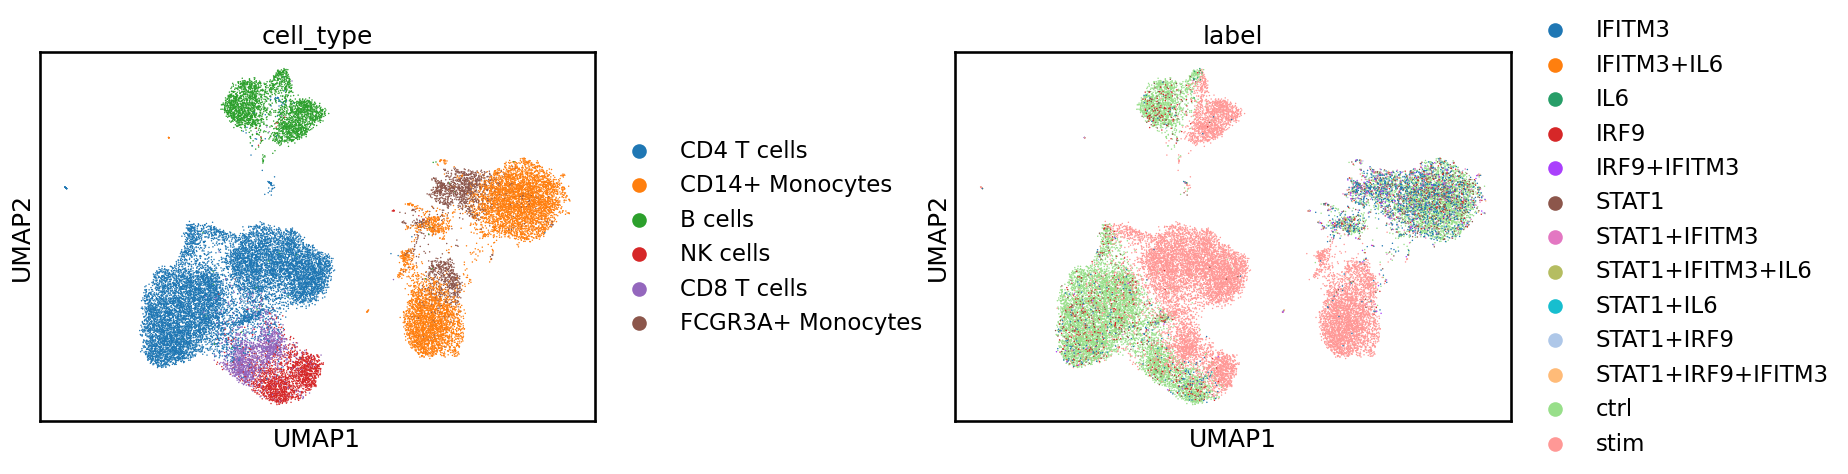

In [16]:
sc.pl.umap(
    adata_with_perturbations,
    color=['cell_type', 'label'],
    wspace=0.5,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


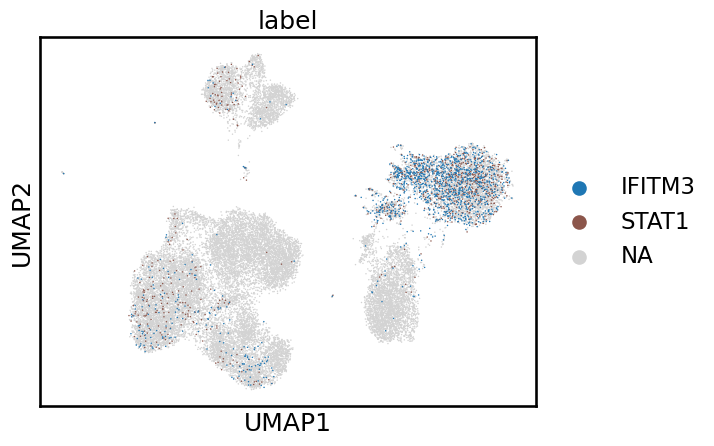

In [17]:
sc.pl.umap(
    adata_with_perturbations,
    color='label',
    groups=['STAT1', 'IFITM3'],
    wspace=0.5,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


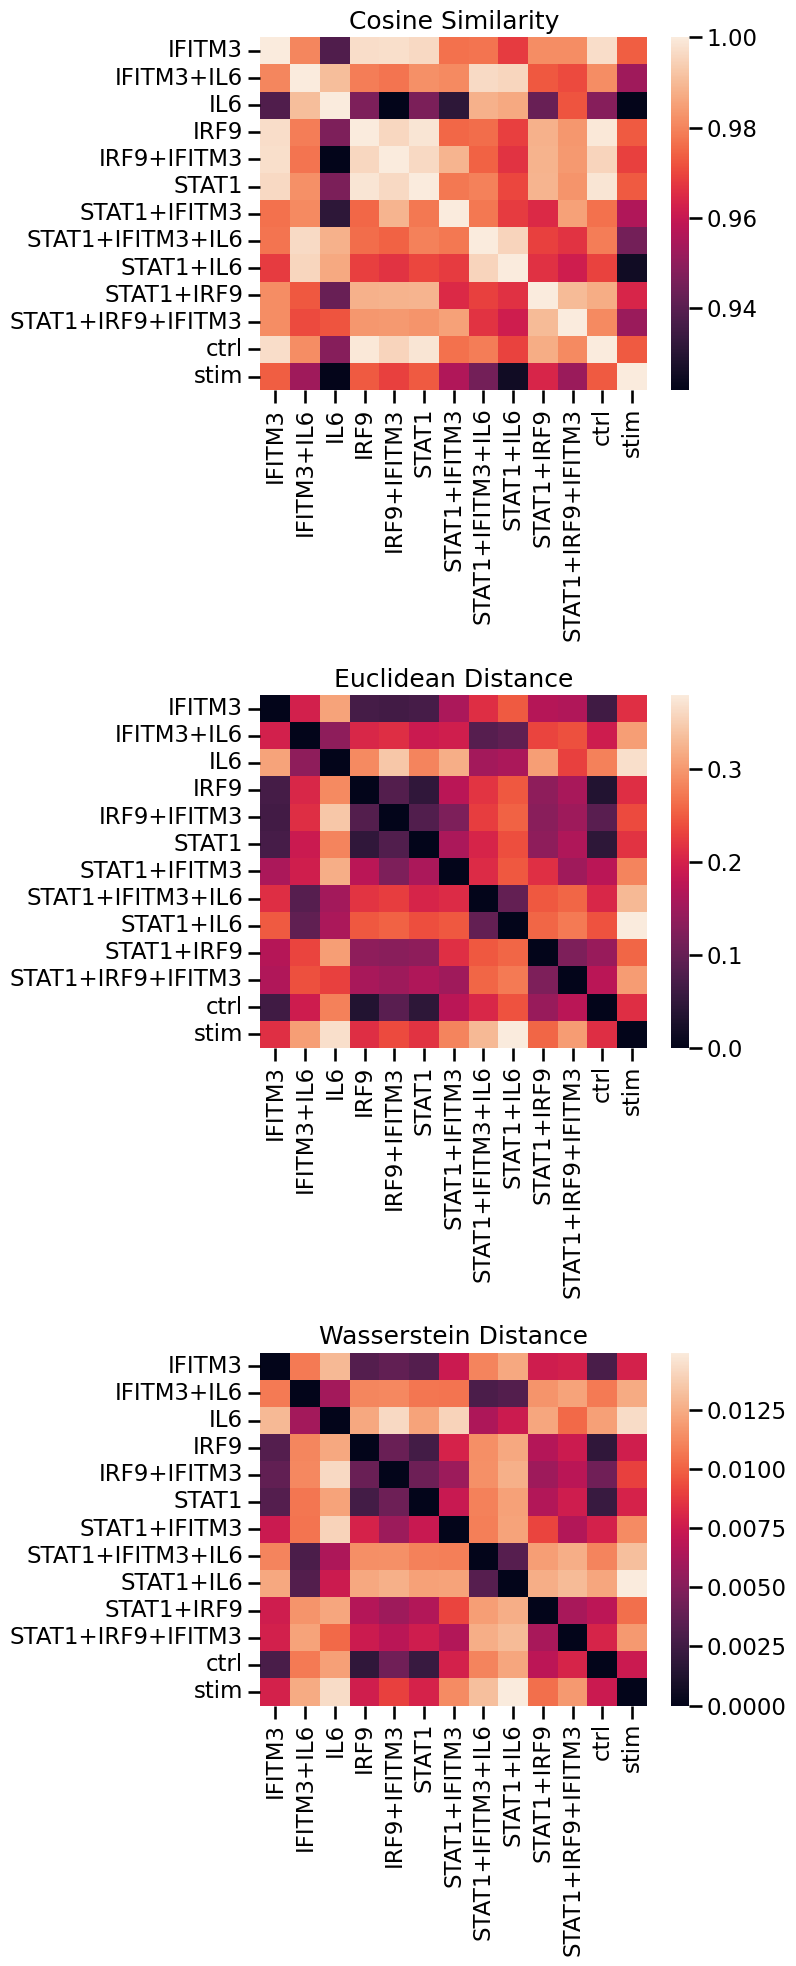

In [18]:
metrics_for_each_ct = plot_metrics(
    adata_with_perturbations,
    obsm_key='X_scGPT',
    perturbation_key='label',
    cell_type_key='cell_type',
)

In [19]:
adata_with_perturbations.obs['label'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
label,
stim,12018
ctrl,11993
IFITM3,1270
STAT1,872
IRF9,609
STAT1+IFITM3,267
IRF9+IFITM3,98
STAT1+IRF9,68
STAT1+IRF9+IFITM3,25


In [20]:
(adata_with_perturbations.obs['label'].value_counts() > 10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
label,
stim,True
ctrl,True
IFITM3,True
STAT1,True
IRF9,True
STAT1+IFITM3,True
IRF9+IFITM3,True
STAT1+IRF9,True
STAT1+IRF9+IFITM3,True


In [21]:
# Count the occurrences of each label
label_counts = adata_with_perturbations.obs['label'].value_counts()

# Identify labels with more than 10 occurrences
valid_labels = label_counts[label_counts > 10].index

adata_to_classify = adata_with_perturbations[adata_with_perturbations.obs['label'].isin(valid_labels)].copy()
adata_to_classify

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AnnData object with n_obs × n_vars = 27239 × 7000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes', 'n_counts', 'total_counts'
    var: 'index', 'id_in_vocab'
    uns: 'neighbors', 'umap', 'cell_type_colors', 'label_colors'
    obsm: 'X_scGPT', 'X_umap'
    obsp: 'distances', 'connectivities'

In [22]:
adata_to_classify.obs['label'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
label,
stim,12018
ctrl,11993
IFITM3,1270
STAT1,872
IRF9,609
STAT1+IFITM3,267
IRF9+IFITM3,98
STAT1+IRF9,68
STAT1+IRF9+IFITM3,25


In [23]:
cell_clf = CellEmbeddingClassifier(
    adata_to_classify,
    obsm_key='X_scGPT',
    perturbation_key='label',
    classifier="mlp",
    classif_params={
        'device': 'cuda',
        'epochs': 100,
        'batch_size': 256,
        'dropout': 0.3,
        'n_layers': 3,
        'hidden_dim': 256,
    },
)

cell_clf.train()

report = cell_clf.evaluate()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch [1/100],                     Loss: 0.631981055057326
Epoch [2/100],                     Loss: 0.49774351958618607
Epoch [3/100],                     Loss: 0.48711016947446867
Epoch [4/100],                     Loss: 0.4777427158036897
Epoch [5/100],                     Loss: 0.4705038004836371
Epoch [6/100],                     Loss: 0.4661508902560833
Epoch [7/100],                     Loss: 0.46653850584529166
Epoch [8/100],                     Loss: 0.4609561792119991
Epoch [9/100],                     Loss: 0.46093552784864295
Epoch [10/100],                     Loss: 0.4639294157887614
Epoch [11/100],                     Loss: 0.4615086084881494
Epoch [12/100],                     Loss: 0.45304231934769207
Epoch [13/100],                     Loss: 0.4502786214268485
Epoch [14/100],                     Loss: 0.44782569796540017
Epoch [15/100],                     Loss: 0.4447756045779517
Epoch [16/100],                     Loss: 0.440606486485448
Epoch [17/100],              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                   precision    recall  f1-score   support

           IFITM3       0.30      0.14      0.19       254
              IL6       0.00      0.00      0.00         4
             IRF9       0.00      0.00      0.00       122
      IRF9+IFITM3       0.00      0.00      0.00        20
            STAT1       0.09      0.01      0.01       174
     STAT1+IFITM3       0.00      0.00      0.00        53
       STAT1+IRF9       0.00      0.00      0.00        13
STAT1+IRF9+IFITM3       0.00      0.00      0.00         5
             ctrl       0.79      0.96      0.87      2399
             stim       0.98      0.98      0.98      2404

         accuracy                           0.86      5448
        macro avg       0.22      0.21      0.21      5448
     weighted avg       0.80      0.86      0.83      5448



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
cell_clf = CellEmbeddingClassifier(
    adata_to_classify,
    obsm_key='X_scGPT',
    perturbation_key='label',
    classifier="dt",
)

cell_clf.train()

report = cell_clf.evaluate()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                   precision    recall  f1-score   support

           IFITM3       0.12      0.13      0.12       254
              IL6       0.00      0.00      0.00         4
             IRF9       0.01      0.02      0.02       122
      IRF9+IFITM3       0.04      0.05      0.04        20
            STAT1       0.03      0.04      0.04       174
     STAT1+IFITM3       0.03      0.04      0.04        53
       STAT1+IRF9       0.10      0.08      0.09        13
STAT1+IRF9+IFITM3       0.00      0.00      0.00         5
             ctrl       0.77      0.73      0.75      2399
             stim       0.91      0.91      0.91      2404

         accuracy                           0.74      5448
        macro avg       0.20      0.20      0.20      5448
     weighted avg       0.75      0.74      0.74      5448



In [25]:
cell_clf = CellEmbeddingClassifier(
    adata_to_classify,
    obsm_key='X_scGPT',
    perturbation_key='label',
    classifier="rf",
)

cell_clf.train()

report = cell_clf.evaluate()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

                   precision    recall  f1-score   support

           IFITM3       0.02      0.00      0.01       254
              IL6       0.00      0.00      0.00         4
             IRF9       0.00      0.00      0.00       122
      IRF9+IFITM3       0.00      0.00      0.00        20
            STAT1       0.00      0.00      0.00       174
     STAT1+IFITM3       0.00      0.00      0.00        53
       STAT1+IRF9       0.00      0.00      0.00        13
STAT1+IRF9+IFITM3       0.00      0.00      0.00         5
             ctrl       0.77      0.97      0.86      2399
             stim       0.98      0.96      0.97      2404

         accuracy                           0.85      5448
        macro avg       0.18      0.19      0.18      5448
     weighted avg       0.77      0.85      0.81      5448



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
cell_clf = CellEmbeddingClassifier(
    adata_to_classify,
    obsm_key='X_scGPT',
    perturbation_key='label',
    classifier="svm",
)

cell_clf.train()

report = cell_clf.evaluate()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                   precision    recall  f1-score   support

           IFITM3       0.00      0.00      0.00       254
              IL6       0.00      0.00      0.00         4
             IRF9       0.00      0.00      0.00       122
      IRF9+IFITM3       0.00      0.00      0.00        20
            STAT1       0.00      0.00      0.00       174
     STAT1+IFITM3       0.00      0.00      0.00        53
       STAT1+IRF9       0.00      0.00      0.00        13
STAT1+IRF9+IFITM3       0.00      0.00      0.00         5
             ctrl       0.78      0.99      0.87      2399
             stim       0.98      0.97      0.98      2404

         accuracy                           0.86      5448
        macro avg       0.18      0.20      0.18      5448
     weighted avg       0.77      0.86      0.81      5448



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
